https://cometscome.github.io/JuliaFromFortran/build/chapter2/01/#%E6%AC%A1%E5%85%83Ising%E6%A8%A1%E5%9E%8B

In [1]:
VERSION

v"1.6.2"

In [2]:
using Plots
using Parameters
using BenchmarkTools

In [3]:
module Orig # a little revised

struct Boundaries
    forward::Array{Int64,1}
    backward::Array{Int64,1}
    function Boundaries(side)
        return new(zeros(Int64,side),zeros(Int64,side))
    end
end

function compute_backward_and_forward(side)
    boundaries = Boundaries(side)
    forward = boundaries.forward
    backward = boundaries.backward
    for position=1:side
        forward[position]=position % side +1
        backward[position]=(position-2+side) % side+1
    end
    return boundaries
end

function one_Monte_Carlo_cycle!(boundaries,spin,side,
    beta,magnetic_field)
    forward = boundaries.forward
    backward = boundaries.backward

    total_magnetization=0.0
    total_energy=0.0

    for y_position=1:side
        @inbounds for x_position=1:side
            current_spin=spin[x_position,y_position]
            sum_of_the_neighbours= 
                spin[x_position,forward[y_position]] + 
                spin[x_position,backward[y_position]]+
                spin[forward[x_position],y_position]+
                spin[backward[x_position],y_position]

            effective_force=sum_of_the_neighbours+magnetic_field
            if exp(-beta*effective_force*current_spin*2) > rand()
                new_spin = -current_spin
            else
                new_spin = current_spin
            end
            spin[x_position,y_position]=new_spin
            total_magnetization=total_magnetization+new_spin
            total_energy = total_energy+
                (0.5*sum_of_the_neighbours+magnetic_field)*new_spin
        end
    end
    magnetization_density=total_magnetization/(side^2)
    energy_density=total_energy/(side^2)

    return energy_density,magnetization_density
end

using Random

function main(;
        side = 2^6,
        number_of_iterations = 10^4, 
        nskips = 10,
        beta = log(1 + √2)/2,
        magnetic_field = 0.0,
        random_seed = 464937337564
    )
    spin = ones(Int8,side,side)
    Random.seed!(random_seed)
    boundaries = compute_backward_and_forward(side)
    
    Spin = Vector{typeof(spin)}(undef, number_of_iterations)
    Energy_density = Vector{Float64}(undef, number_of_iterations)
    Magnetization_density = similar(Energy_density)
    for iteration in 1:number_of_iterations
        for _ in 1:nskips-1
            one_Monte_Carlo_cycle!(boundaries,spin,side,beta,magnetic_field)
        end
        Energy_density[iteration], Magnetization_density[iteration] = 
                one_Monte_Carlo_cycle!(boundaries,spin,side,beta,magnetic_field)
        Spin[iteration] = copy(spin)
    end
    Spin, Energy_density, Magnetization_density
end

@time Spin, Energy_density, Magnetization_density = Orig.main()

end

@unpack Spin, Energy_density, Magnetization_density = Orig
Spin, Energy_density, Magnetization_density

  6.928129 seconds (10.03 k allocations: 41.147 MiB, 0.13% gc time)


(Matrix{Int8}[[1 1 … -1 -1; 1 1 … 1 1; … ; 1 1 … 1 1; 1 1 … -1 1], [1 1 … 1 1; -1 -1 … 1 1; … ; 1 1 … -1 1; 1 1 … 1 1], [1 1 … 1 1; 1 1 … -1 -1; … ; 1 1 … 1 1; 1 1 … 1 1], [1 -1 … 1 1; 1 1 … 1 1; … ; 1 1 … 1 1; 1 1 … 1 1], [1 1 … 1 1; 1 1 … 1 1; … ; 1 1 … 1 1; 1 1 … 1 1], [1 1 … 1 1; 1 1 … 1 1; … ; 1 1 … -1 1; 1 1 … 1 1], [1 1 … 1 1; 1 1 … 1 1; … ; 1 1 … 1 1; 1 1 … 1 1], [1 1 … 1 1; 1 1 … -1 1; … ; 1 1 … 1 1; 1 1 … 1 1], [-1 -1 … -1 -1; -1 -1 … -1 -1; … ; -1 -1 … -1 1; -1 -1 … -1 -1], [1 -1 … -1 -1; -1 -1 … 1 -1; … ; -1 1 … -1 -1; 1 1 … -1 -1]  …  [-1 1 … -1 -1; -1 -1 … -1 -1; … ; -1 1 … -1 -1; -1 -1 … -1 -1], [-1 -1 … -1 -1; -1 -1 … -1 -1; … ; -1 -1 … -1 -1; -1 -1 … 1 -1], [1 -1 … 1 1; 1 -1 … 1 1; … ; -1 -1 … -1 -1; 1 -1 … 1 1], [-1 -1 … -1 -1; 1 -1 … 1 1; … ; -1 -1 … -1 -1; -1 -1 … -1 -1], [-1 -1 … -1 -1; -1 -1 … -1 -1; … ; 1 -1 … -1 -1; -1 -1 … -1 -1], [1 -1 … -1 -1; -1 -1 … -1 -1; … ; -1 -1 … 1 -1; -1 -1 … -1 -1], [-1 -1 … -1 -1; -1 -1 … -1 -1; … ; -1 -1 … -1 -1; -1 -1 … -1 -1], [-

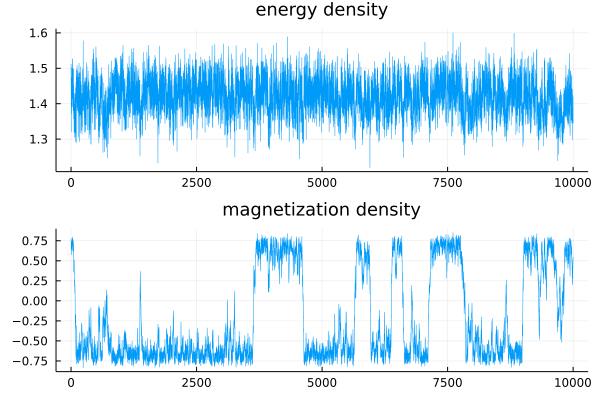

┌ Info: Saved animation to 
│   fn = D:\OneDrive\public\0019\tmp.gif
└ @ Plots D:\.julia\packages\Plots\Di0Qb\src\animation.jl:114


Plots.AnimatedGif("D:\\OneDrive\\public\\0019\\tmp.gif")
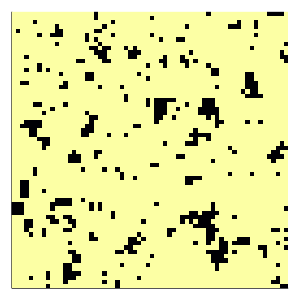

In [4]:
P = plot(Energy_density; label="", title="energy density", lw=0.5)
Q = plot(Magnetization_density; label="", title="magnetization density", lw=0.5)
plot(P, Q; layout=(2, 1), titlefontsize=12) |> display

@gif for k in 1:100
    heatmap(Spin[k]; size=(300, 300), colorbar=false, ticks=false, axes=false)
end

In [5]:
module My

using ConcreteStructs
using Parameters
using ProgressMeter

@concrete struct Model side; beta; magnetic_field; prob_n; prob_mf end
function Model(side, beta, magnetic_field)
    prob_n = ntuple(i -> exp(-2beta*(i - 5)), 9)
    prob_mf = ntuple(i -> exp(-2beta*magnetic_field*(i - 2)), 3)
    Model(side, beta, magnetic_field, prob_n, prob_mf)
end

forward(i, m) = ifelse(i == m, 1, i+1)
backward(i, m) = ifelse(i == 1, m, i-1)

function one_Monte_Carlo_cycle!(model::Model, spin, rng=Random.default_rng())
    @unpack side, beta, magnetic_field, prob_n, prob_mf = model
    total_magnetization = 0.0
    total_energy = 0.0

    for y_position=1:side
        @inbounds for x_position=1:side
            current_spin = spin[x_position, y_position]
            sum_of_the_neighbours = 
                spin[x_position, forward(y_position, side)] + 
                spin[x_position, backward(y_position, side)] +
                spin[forward(x_position, side), y_position] +
                spin[backward(x_position, side), y_position]
            if rand(rng) < prob_n[sum_of_the_neighbours*current_spin + 5] * prob_mf[current_spin + 2]
                new_spin = -current_spin
            else
                new_spin = current_spin
            end
            spin[x_position, y_position] = new_spin
            total_magnetization = total_magnetization+new_spin
            total_energy = total_energy +
                (0.5sum_of_the_neighbours + magnetic_field)*new_spin
        end
    end
    magnetization_density = total_magnetization / side^2
    energy_density = total_energy / side^2

    return energy_density, magnetization_density
end

using Random

function main(;
        side = 2^6,
        number_of_iterations = 10^4, 
        nskips = 10,
        beta = log(1 + √2)/2,
        magnetic_field = 0.0,
        random_seed = 464937337564
    )
    model = Model(side, beta, magnetic_field)
    spin = ones(Int8, side, side)
    
    Spin = Vector{typeof(spin)}(undef, number_of_iterations)
    Energy_density = Vector{Float64}(undef, number_of_iterations)
    Magnetization_density = similar(Energy_density)
    
    rng = Random.default_rng()
    Random.seed!(random_seed)
    for iteration in 1:number_of_iterations
        for _ in 1:nskips-1
            one_Monte_Carlo_cycle!(model, spin, rng)
        end
        Energy_density[iteration], Magnetization_density[iteration] = 
                one_Monte_Carlo_cycle!(model, spin, rng)
        Spin[iteration] = copy(spin)
    end
    Spin, Energy_density, Magnetization_density
end

@time Spin, Energy_density, Magnetization_density = My.main(magnetic_field = 0.0)

end

@unpack Spin, Energy_density, Magnetization_density = My
Spin, Energy_density, Magnetization_density

  2.157998 seconds (10.01 k allocations: 41.127 MiB, 0.43% gc time)


(Matrix{Int8}[[1 1 … -1 -1; 1 1 … 1 1; … ; 1 1 … 1 1; 1 1 … -1 1], [1 1 … 1 1; -1 -1 … 1 1; … ; 1 1 … -1 1; 1 1 … 1 1], [1 1 … 1 1; 1 1 … -1 -1; … ; 1 1 … 1 1; 1 1 … 1 1], [1 -1 … 1 1; 1 1 … 1 1; … ; 1 1 … 1 1; 1 1 … 1 1], [1 1 … 1 1; 1 1 … 1 1; … ; 1 1 … 1 1; 1 1 … 1 1], [1 1 … 1 1; 1 1 … 1 1; … ; 1 1 … -1 1; 1 1 … 1 1], [1 1 … 1 1; 1 1 … 1 1; … ; 1 1 … 1 1; 1 1 … 1 1], [1 1 … 1 1; 1 1 … -1 1; … ; 1 1 … 1 1; 1 1 … 1 1], [-1 -1 … -1 -1; -1 -1 … -1 -1; … ; -1 -1 … -1 1; -1 -1 … -1 -1], [1 -1 … -1 -1; -1 -1 … 1 -1; … ; -1 1 … -1 -1; 1 1 … -1 -1]  …  [-1 1 … -1 -1; -1 -1 … -1 -1; … ; -1 1 … -1 -1; -1 -1 … -1 -1], [-1 -1 … -1 -1; -1 -1 … -1 -1; … ; -1 -1 … -1 -1; -1 -1 … 1 -1], [1 -1 … 1 1; 1 -1 … 1 1; … ; -1 -1 … -1 -1; 1 -1 … 1 1], [-1 -1 … -1 -1; 1 -1 … 1 1; … ; -1 -1 … -1 -1; -1 -1 … -1 -1], [-1 -1 … -1 -1; -1 -1 … -1 -1; … ; 1 -1 … -1 -1; -1 -1 … -1 -1], [1 -1 … -1 -1; -1 -1 … -1 -1; … ; -1 -1 … 1 -1; -1 -1 … -1 -1], [-1 -1 … -1 -1; -1 -1 … -1 -1; … ; -1 -1 … -1 -1; -1 -1 … -1 -1], [-

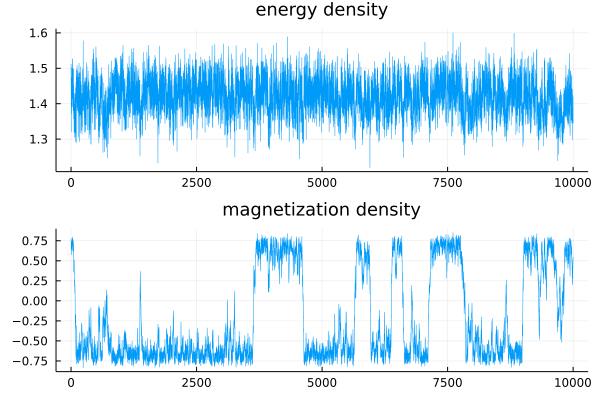

┌ Info: Saved animation to 
│   fn = D:\OneDrive\public\0019\tmp.gif
└ @ Plots D:\.julia\packages\Plots\Di0Qb\src\animation.jl:114


Plots.AnimatedGif("D:\\OneDrive\\public\\0019\\tmp.gif")
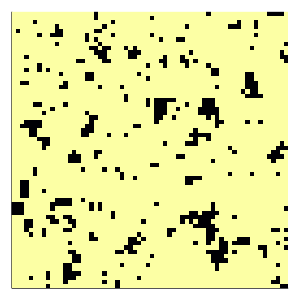

In [6]:
P = plot(Energy_density; label="", title="energy density", lw=0.5)
Q = plot(Magnetization_density; label="", title="magnetization density", lw=0.5)
plot(P, Q; layout=(2, 1), titlefontsize=12) |> display

@gif for k in 1:100
    heatmap(Spin[k]; size=(300, 300), colorbar=false, ticks=false, axes=false)
end

In [7]:
@show Orig.main(number_of_iterations = 100) == My.main(number_of_iterations = 100)
@btime Orig.main(number_of_iterations = 100)
@btime My.main(number_of_iterations = 100);

Orig.main(number_of_iterations = 100) == My.main(number_of_iterations = 100) = true
  68.205 ms (110 allocations: 426.93 KiB)
  20.559 ms (108 allocations: 425.71 KiB)
